# Turbo Jet Engine Predictive Maintenance

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from keras import models, layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

## Defined Functions

In [2]:
def loadData():
    dirPath = 'D:/IIT DHANBAD/Seventh semester/CSC 401- Project - I -PI/Practice/Dataset/'
    trainTxtFiles = ['train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt']
    testTxtFiles = ['test_FD001.txt', 'test_FD002.txt', 'test_FD003.txt', 'test_FD004.txt']
    rulTxtFiles = ['RUL_FD001.txt', 'RUL_FD002.txt', 'RUL_FD003.txt', 'RUL_FD004.txt']
    trueRulTxtFile = ['x.txt']
    
    trainTestColumns = ['Unit Number', 'Time (Cycles)', 'OP1', 'OP2', 'OP3', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21']
    
    trainDatasets = []
    testDatasets = []
    expectedRulDatasets = []
    
    for i in range(4):
        # Import Files
        tempTrain = pd.read_csv( dirPath + trainTxtFiles[i], sep = " ", header = None)
        tempTest = pd.read_csv( dirPath + testTxtFiles[i], sep = " ", header = None)
        tempRul = pd.read_csv( dirPath + rulTxtFiles[i], sep = " ", header = None)

        # Cleaning Files
        tempTrain.drop(inplace = True, columns = [26, 27])
        tempTest.drop(inplace = True, columns = [26, 27])
        tempRul.drop(inplace = True, columns = [1])

        # Adding Columns Names
        tempTrain.columns = tempTest.columns = trainTestColumns
        tempRul.columns = ["Expected RUL"]

        # Appending to Lists
        trainDatasets.append(tempTrain)
        testDatasets.append(tempTest)
        expectedRulDatasets.append(tempRul)
    
    return trainDatasets, testDatasets, expectedRulDatasets

In [3]:
def checkBasicStructure(trainDatasets, testDatasets, expectedRulDatasets):
    print("\nDatasets Example\n")
    for i in range(4):
        print("For FD00" + str(i+1) )
        print("\nTrain Dataset")
        display(trainDatasets[i].head())
    
        print("\nTest Dataset")
        display(testDatasets[i].head())
    
        print("\nExpected RUL")
        display(expectedRulDatasets[i].head())
        print("\n")

In [4]:
def checkForNA(trainDatasets, testDatasets, expectedRulDatasets):
    print("\nDatasets Example\n")
    for i in range(4):
        print("For FD00" + str(i+1))
        print("\nTrain Dataset")
        display(trainDatasets[i].isna().sum())
    
        print("\nTest Dataset")
        display(testDatasets[i].isna().sum())
    
        print("\nExpected RUL")
        display(expectedRulDatasets[i].isna().sum())
        print("\n")

In [5]:
def findRul(Datasets):

    rulDatasets = []
    
    for i in range(4):
        # Finding Maximum RUL
        temp = copy.deepcopy(Datasets[i].iloc[:, 0:2])
        tempRul = temp.groupby(Datasets[i].columns[0])[Datasets[i].columns[1]].max()

        # Create Max RUL Dataframe
        tempRul = pd.DataFrame(tempRul)
        tempRul.columns = ["Max"]
        tempRul = pd.merge(temp, tempRul, left_on = Datasets[i].columns[0], right_on = Datasets[i].columns[0])
        tempRul["RUL"] = tempRul["Max"] - tempRul[Datasets[i].columns[1]];
        tempRul.drop(inplace = True, columns = ["Max", Datasets[i].columns[1]])
        
        # Appending to List
        rulDatasets.append(tempRul)

    return rulDatasets

In [6]:
def checkRulBasicStructure(rulDatasets):
    print("\nRUL Datasets Example\n")
    for i in range(4):
        print("For FD00" + str(i+1) )
        print("\nExpected RUL")
        display(rulDatasets[i].head())
        print("\n")

In [7]:
def processTrainingData(dataset, rulDataset = None, window = 1, shift = 1):
    partitions = int(np.floor((len(dataset) - window) / shift)) + 1
    features = dataset.shape[1]

    processedData = np.repeat(np.nan, repeats = partitions * window * features).reshape(partitions, window, features)

    if rulDataset is None:
        for i in range(partitions):
            processedData[i, :, :] = dataset[(0 + shift * i): (0 + shift * i + window), :]
            
        return processedData

    processedRul = np.repeat(np.nan, repeats = partitions)
    for i in range(partitions):
        processedData[i, :, :] = dataset[(0 + shift * i): (0 + shift * i + window), :]
        processedRul[i] = rulDataset[(shift * i + (window - 1))]

    return processedData, processedRul

In [8]:
def processTestingData(dataset, window, shift, testWindow = 1):
    maxPartitions = int(np.floor((len(dataset) - window) / shift)) + 1

    if maxPartitions < testWindow:
        newLen = (maxPartitions - 1) * shift + window

        processedData = processTrainingData(dataset[-newLen:, :] , window = window, shift = shift)

        return processedData, maxPartitions

    newLen = (testWindow - 1) * shift + window

    processedData = processTrainingData(dataset[-newLen:, :] , window = window, shift = shift)

    return processedData, testWindow

In [9]:
def createModel(shape, name = "Combined"):
    model = Sequential(name = name)
    model.add(LSTM(128, return_sequences = True, input_shape = (shape[1], shape[2])))
    model.add(LSTM(64 ,return_sequences = True))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001))

    return model

## Loading and Checking Dataset

In [10]:
trainDatasets, testDatasets, expectedRulDatasets = loadData()

### Check Basic Structure

In [11]:
checkBasicStructure(trainDatasets, testDatasets, expectedRulDatasets)


Datasets Example

For FD001

Train Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044



Test Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130



Expected RUL


,Expected RUL
0,112
1,98
2,69
3,82
4,91




For FD002

Train Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286



Test Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,371.69,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,315.32,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,183.04,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,130.40,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,164.56,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740



Expected RUL


,Expected RUL
0,18
1,79
2,106
3,110
4,15




For FD003

Train Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583



Test Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,...,521.89,2387.94,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468
1,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,...,521.85,2388.01,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807
2,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,...,522.10,2387.94,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244
3,1,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,1395.34,14.62,...,522.45,2387.96,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782
4,1,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,1395.86,14.62,...,521.91,2387.97,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950



Expected RUL


,Expected RUL
0,44
1,51
2,27
3,120
4,101




For FD004

Train Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754



Test Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,313.03,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,163.61,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,129.98,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,129.48,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,181.82,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326



Expected RUL


,Expected RUL
0,22
1,39
2,107
3,75
4,149


### Check For NAs

In [12]:
checkForNA(trainDatasets, testDatasets, expectedRulDatasets)


Datasets Example

For FD001

Train Dataset


Unit Number      0
Time (Cycles)    0
OP1              0
OP2              0
OP3              0
S1               0
S2               0
S3               0
S4               0
S5               0
S6               0
S7               0
S8               0
S9               0
S10              0
S11              0
S12              0
S13              0
S14              0
S15              0
S16              0
S17              0
S18              0
S19              0
S20              0
S21              0
dtype: int64


Test Dataset


Unit Number      0
Time (Cycles)    0
OP1              0
OP2              0
OP3              0
S1               0
S2               0
S3               0
S4               0
S5               0
S6               0
S7               0
S8               0
S9               0
S10              0
S11              0
S12              0
S13              0
S14              0
S15              0
S16              0
S17              0
S18              0
S19              0
S20              0
S21              0
dtype: int64


Expected RUL


Expected RUL    0
dtype: int64



For FD002

Train Dataset


Unit Number      0
Time (Cycles)    0
OP1              0
OP2              0
OP3              0
S1               0
S2               0
S3               0
S4               0
S5               0
S6               0
S7               0
S8               0
S9               0
S10              0
S11              0
S12              0
S13              0
S14              0
S15              0
S16              0
S17              0
S18              0
S19              0
S20              0
S21              0
dtype: int64


Test Dataset


Unit Number      0
Time (Cycles)    0
OP1              0
OP2              0
OP3              0
S1               0
S2               0
S3               0
S4               0
S5               0
S6               0
S7               0
S8               0
S9               0
S10              0
S11              0
S12              0
S13              0
S14              0
S15              0
S16              0
S17              0
S18              0
S19              0
S20              0
S21              0
dtype: int64


Expected RUL


Expected RUL    0
dtype: int64



For FD003

Train Dataset


Unit Number      0
Time (Cycles)    0
OP1              0
OP2              0
OP3              0
S1               0
S2               0
S3               0
S4               0
S5               0
S6               0
S7               0
S8               0
S9               0
S10              0
S11              0
S12              0
S13              0
S14              0
S15              0
S16              0
S17              0
S18              0
S19              0
S20              0
S21              0
dtype: int64


Test Dataset


Unit Number      0
Time (Cycles)    0
OP1              0
OP2              0
OP3              0
S1               0
S2               0
S3               0
S4               0
S5               0
S6               0
S7               0
S8               0
S9               0
S10              0
S11              0
S12              0
S13              0
S14              0
S15              0
S16              0
S17              0
S18              0
S19              0
S20              0
S21              0
dtype: int64


Expected RUL


Expected RUL    0
dtype: int64



For FD004

Train Dataset


Unit Number      0
Time (Cycles)    0
OP1              0
OP2              0
OP3              0
S1               0
S2               0
S3               0
S4               0
S5               0
S6               0
S7               0
S8               0
S9               0
S10              0
S11              0
S12              0
S13              0
S14              0
S15              0
S16              0
S17              0
S18              0
S19              0
S20              0
S21              0
dtype: int64


Test Dataset


Unit Number      0
Time (Cycles)    0
OP1              0
OP2              0
OP3              0
S1               0
S2               0
S3               0
S4               0
S5               0
S6               0
S7               0
S8               0
S9               0
S10              0
S11              0
S12              0
S13              0
S14              0
S15              0
S16              0
S17              0
S18              0
S19              0
S20              0
S21              0
dtype: int64


Expected RUL


Expected RUL    0
dtype: int64

## Preprocessing Datasets

In [13]:
trainDatasetsCopy = copy.deepcopy(trainDatasets)
testDatasetsCopy = copy.deepcopy(testDatasets)
expectedRulDatasetsCopy = copy.deepcopy(expectedRulDatasets)

### Converting to Standardize Distribution

In [14]:
scaler = []

for i in range(4):
    sc = StandardScaler()
    scaler.append(sc)

In [15]:
for i in range(4):
    trainDatasetsCopy[i].iloc[:, 2:] = scaler[i].fit_transform(trainDatasetsCopy[i].iloc[:, 2:])
    testDatasetsCopy[i].iloc[:, 2: ] = scaler[i].transform(testDatasetsCopy[i].iloc[:, 2:])

In [16]:
checkBasicStructure(trainDatasetsCopy, testDatasetsCopy, expectedRulDatasetsCopy)


Datasets Example

For FD001

Train Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,-0.315980,-1.372953,0.0,0.0,-1.721725,-0.134255,-0.925936,-1.776357e-15,...,0.334262,-1.058890,-0.269071,-0.603816,-1.387779e-17,-0.781710,0,0.0,1.348493,1.194427
1,1,2,0.872722,-1.031720,0.0,0.0,-1.061780,0.211528,-0.643726,-1.776357e-15,...,1.174899,-0.363646,-0.642845,-0.275852,-1.387779e-17,-0.781710,0,0.0,1.016528,1.236922
2,1,3,-1.961874,1.015677,0.0,0.0,-0.661813,-0.413166,-0.525953,-1.776357e-15,...,1.364721,-0.919841,-0.551629,-0.649144,-1.387779e-17,-2.073094,0,0.0,0.739891,0.503423
3,1,4,0.324090,-0.008022,0.0,0.0,-0.661813,-1.261314,-0.784831,-1.776357e-15,...,1.961302,-0.224597,-0.520176,-1.971665,-1.387779e-17,-0.781710,0,0.0,0.352598,0.777792
4,1,5,-0.864611,-0.690488,0.0,0.0,-0.621816,-1.251528,-0.301518,-1.776357e-15,...,1.052871,-0.780793,-0.521748,-0.339845,-1.387779e-17,-0.136018,0,0.0,0.463253,1.059552



Test Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,1.055599,1.015677,0.0,0.0,0.678077,-0.853550,-1.191480,-1.776357e-15,...,0.415614,-0.919841,-0.954235,-0.985107,-1.387779e-17,-0.781710,0,0.0,0.241943,0.774097
1,1,2,-1.230366,-1.031720,0.0,0.0,-1.941707,-0.338137,-1.501467,-1.776357e-15,...,1.012195,-0.502695,-0.216648,-1.649034,-1.387779e-17,-0.136018,0,0.0,1.127183,0.941305
2,1,3,0.141213,0.333211,0.0,0.0,-0.441831,-0.584426,-0.843717,-1.776357e-15,...,0.754581,-0.919841,-0.715712,0.052112,-1.387779e-17,-0.136018,0,0.0,1.459148,1.172256
3,1,4,1.924266,-0.008022,0.0,0.0,-0.481827,-1.044384,-0.279297,-1.776357e-15,...,-0.045381,-0.641744,-0.568929,-1.345067,-1.387779e-17,-1.427402,0,0.0,1.016528,0.775945
4,1,5,0.644125,-0.008022,0.0,0.0,-0.341839,-0.543650,-0.779276,-1.776357e-15,...,0.998637,-0.919841,-0.745069,-1.041101,-1.387779e-17,-2.073094,0,0.0,0.961200,1.138999



Expected RUL


,Expected RUL
0,112
1,98
2,69
3,82
4,91




For FD002

Train Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,0.745895,0.864298,0.418187,-0.889378,-0.653071,-0.579176,-0.572622,-0.706177,...,-0.603008,0.415116,-0.212615,0.021948,-0.705933,-0.515579,-0.039954,0.418187,-0.613958,-0.619148
1,1,2,1.220553,0.866878,0.418187,-1.057627,-0.798422,-0.630051,-0.668741,-1.140622,...,-0.985404,0.414648,0.067215,0.063719,-0.705933,-0.659701,-0.115645,0.418187,-1.051681,-1.048190
2,1,3,0.067836,0.160457,-2.391275,-0.392968,-1.136055,-1.540521,-1.326301,-0.271732,...,-0.739869,-2.393490,-2.377822,2.087798,-0.705933,-1.416342,-2.159318,-2.391275,-0.679819,-0.641912
3,1,4,1.221198,0.869459,0.418187,-1.057627,-0.808881,-0.622406,-0.663705,-1.140622,...,-0.983225,0.414257,0.024309,0.030890,-0.705933,-0.695731,-0.115645,0.418187,-1.033443,-1.013808
4,1,5,0.067951,0.155618,-2.391275,-0.392968,-1.142491,-1.531554,-1.322271,-0.271732,...,-0.739215,-2.393724,-2.420728,2.090734,-0.705933,-1.416342,-2.159318,-2.391275,-0.674753,-0.666180



Test Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,-0.949310,-1.038202,0.418187,0.611600,0.680028,0.728668,0.835679,0.688475,...,0.767270,0.418708,0.559923,-0.910220,1.416565,0.745489,0.620627,0.418187,0.773181,0.790616
1,1,2,-0.270953,0.412704,0.418187,0.692693,0.754849,0.577930,0.341397,0.364716,...,0.357777,0.418240,-0.159573,-0.118978,-0.705933,0.565336,0.655032,0.418187,0.354709,0.393558
2,1,3,0.746315,0.864298,0.418187,-0.889378,-0.634835,-0.574740,-0.647083,-0.706177,...,-0.603153,0.415351,-0.159808,0.023416,-0.705933,-0.551609,-0.039954,0.418187,-0.588627,-0.601349
3,1,4,1.221123,0.867523,0.418187,-1.057627,-0.791181,-0.663370,-0.651028,-1.140622,...,-0.985550,0.415116,0.003564,0.088675,-0.705933,-0.587640,-0.115645,0.418187,-1.057761,-1.022589
4,1,5,0.067816,0.158844,-2.391275,-0.392968,-1.151877,-1.574312,-1.299102,-0.271732,...,-0.737399,-2.393334,-2.368510,2.053234,-0.705933,-1.560464,-2.159318,-2.391275,-0.656514,-0.658513



Expected RUL


,Expected RUL
0,18
1,79
2,106
3,110
4,15




For FD003

Train Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,-0.217122,1.343135,0.0,0.0,-0.187102,-0.712038,-0.780848,-3.552714e-15,...,-0.227593,-0.389857,0.067687,0.469741,-1.734723e-17,-0.889364,0,0.0,0.488019,-0.263512
1,1,2,0.375538,-1.037519,0.0,0.0,0.080574,-0.497656,-0.775732,-3.552714e-15,...,-0.193802,-0.263369,0.523946,0.729201,-1.734723e-17,-0.321641,0,0.0,0.005819,0.375767
2,1,3,-0.627426,-0.697425,0.0,0.0,-0.531256,-0.841254,0.116524,-3.552714e-15,...,-0.313608,-0.453101,0.361559,-0.100409,-1.734723e-17,-0.889364,0,0.0,-0.556747,-0.175058
3,1,4,-0.900961,0.322855,0.0,0.0,0.883602,-0.362566,-1.248464,-3.552714e-15,...,-0.172298,0.052852,0.142821,-0.138419,-1.734723e-17,-0.321641,0,0.0,-0.114730,-0.656192
4,1,5,0.740252,-0.017239,0.0,0.0,-1.487242,0.080881,-0.697966,-3.552714e-15,...,-0.144650,-0.263369,0.217955,-0.153292,-1.734723e-17,-0.321641,0,0.0,0.608569,0.437416



Test Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,-0.764193,-1.377612,0.0,0.0,-0.990129,-0.902925,-0.771639,-3.552714e-15,...,-0.356616,-0.832566,-0.649725,-0.333427,-1.734723e-17,-0.889364,0,0.0,0.327286,0.360354
1,1,2,0.284359,-0.697425,0.0,0.0,-0.837172,-0.472693,-0.570063,-3.552714e-15,...,-0.368904,-0.389857,-0.409780,0.165661,-1.734723e-17,-0.889364,0,0.0,0.206736,0.587519
2,1,3,0.649073,-1.037519,0.0,0.0,-1.487242,-0.924951,-1.284277,-3.552714e-15,...,-0.292104,-0.832566,-0.360700,-0.675517,-1.734723e-17,-0.889364,0,0.0,0.447836,0.210251
3,1,4,1.241733,0.322855,0.0,0.0,-0.493017,-0.521150,-0.934332,-3.552714e-15,...,-0.184586,-0.706078,-0.432199,-0.417710,-1.734723e-17,-0.321641,0,0.0,-0.074547,0.570767
4,1,5,-0.034765,0.322855,0.0,0.0,0.004095,0.139616,-0.881124,-3.552714e-15,...,-0.350472,-0.642833,-0.606098,0.304480,-1.734723e-17,-0.889364,0,0.0,0.407652,0.013241



Expected RUL


,Expected RUL
0,44
1,51
2,27
3,120
4,101




For FD004

Train Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,1.218156,0.864668,0.418783,-1.054690,-0.796416,-0.701412,-0.745729,-1.137677,...,-0.989007,0.417814,0.081921,0.063831,-0.694278,-0.638665,-0.114203,0.418783,-1.030999,-1.031756
1,1,2,-0.270478,0.414718,0.418783,0.692508,0.713666,0.562449,0.298212,0.363906,...,0.331131,0.415786,-0.253086,-0.125677,-0.694278,0.476120,0.655708,0.418783,0.352814,0.358264
2,1,3,1.218082,0.867565,0.418783,-1.054690,-0.815965,-0.704332,-0.711202,-1.137677,...,-0.990162,0.417658,-0.013912,0.153387,-0.694278,-0.674626,-0.114203,0.418783,-1.045089,-1.022649
3,1,4,1.217824,0.864668,0.418783,-1.054690,-0.822660,-0.722040,-0.702990,-1.137677,...,-0.988862,0.418048,0.096162,0.068362,-0.694278,-0.710586,-0.114203,0.418783,-1.039051,-1.023269
4,1,5,0.068094,0.158844,-2.387873,-0.391216,-1.160079,-1.532181,-1.410627,-0.270955,...,-0.741097,-2.389666,-2.358027,2.066982,-0.694278,-1.537685,-2.155843,-2.387873,-0.687814,-0.644612



Test Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,-0.270126,0.414074,0.418783,0.692508,0.729733,0.594757,0.217006,0.363906,...,0.334308,0.416176,-0.219818,-0.083564,-0.694278,0.512081,0.655708,0.418783,0.346775,0.365895
1,1,2,0.067560,0.156591,-2.387873,-0.391216,-1.156865,-1.523327,-1.428310,-0.270955,...,-0.744708,-2.389588,-2.385341,2.102432,-0.694278,-1.501724,-2.155843,-2.387873,-0.654602,-0.661484
2,1,3,1.217824,0.871105,0.418783,-1.054690,-0.808467,-0.732495,-0.804811,-1.137677,...,-0.987563,0.417502,0.038732,0.147123,-0.694278,-0.710586,-0.114203,0.418783,-1.054147,-1.020100
3,1,4,1.218061,0.865312,0.418783,-1.054690,-0.809538,-0.736545,-0.793246,-1.137677,...,-0.991173,0.417112,0.129313,0.098347,-0.694278,-0.710586,-0.114203,0.418783,-1.037038,-1.053608
4,1,5,0.744765,0.864668,0.418783,-0.886741,-0.651273,-0.610894,-0.704917,-0.704316,...,-0.613207,0.416878,-0.116515,0.023184,-0.694278,-0.530782,-0.038587,0.418783,-0.605288,-0.601477



Expected RUL


,Expected RUL
0,22
1,39
2,107
3,75
4,149


### Doing Principal Component Analysis

In [17]:
pca = PCA(n_components = 10)

In [18]:
newColumns = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10']

for i in range(4):
    # Finding Principal Components
    temp1 = pca.fit_transform(trainDatasetsCopy[i].iloc[:, 2:])
    temp2 = pca.transform(testDatasetsCopy[i].iloc[:, 2:])

    # Converting to Dataframes
    temp1 = pd.DataFrame(temp1, columns = newColumns)
    temp2 = pd.DataFrame(temp2, columns = newColumns)

    # Dropping Excess Data
    trainDatasetsCopy[i].drop(inplace = True, columns = trainDatasetsCopy[i].columns[2:])
    testDatasetsCopy[i].drop(inplace = True, columns = testDatasetsCopy[i].columns[2:])

    # Merging New Data
    trainDatasetsCopy[i] = pd.merge(trainDatasetsCopy[i], temp1, left_index=True, right_index=True)
    testDatasetsCopy[i] = pd.merge(testDatasetsCopy[i], temp2, left_index=True, right_index=True)

In [19]:
checkBasicStructure(trainDatasetsCopy, testDatasetsCopy, expectedRulDatasetsCopy)


Datasets Example

For FD001

Train Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,1,-2.952779,-0.432156,-1.172843,0.478171,-0.668797,0.817216,0.637089,-0.347993,0.030831,0.642404
1,1,2,-2.363669,-0.786872,-0.132349,1.153850,-0.702399,0.976451,0.301464,-0.021018,-0.316129,0.656538
2,1,3,-2.978665,-0.552466,-0.530408,-2.124418,0.376082,0.572007,-1.122427,-0.461569,0.254894,0.096212
3,1,4,-3.384151,-0.843788,0.255770,0.134290,-0.337991,-0.399344,-0.050440,0.127225,-0.115972,-1.127490
4,1,5,-2.428327,-0.363296,-1.024880,-0.306351,-0.352159,-0.732400,0.355341,0.068085,-0.488117,0.225827



Test Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,1,-2.475403,-0.777619,1.482786,0.080010,-0.077868,-0.337896,-0.826615,0.921520,-0.393515,-0.616565
1,1,2,-3.566323,-0.040873,-1.520490,-0.408165,-0.459367,0.561212,1.260243,-0.117897,0.206018,-0.495765
2,1,3,-2.336877,-0.379826,0.385361,-0.196137,-0.169551,-0.050891,0.401225,0.680498,-0.077260,1.011673
3,1,4,-2.850192,-0.810491,1.328483,1.310859,-0.576017,-0.068813,-0.668261,0.035846,0.225531,-0.174019
4,1,5,-3.494312,-0.752334,0.477794,0.370824,-0.401362,0.567157,-1.189312,0.103837,-0.134968,0.041174



Expected RUL


,Expected RUL
0,112
1,98
2,69
3,82
4,91




For FD002

Train Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,1,-2.193283,-1.610639,0.172923,-0.044703,-0.465595,-0.035497,-0.086489,0.084043,0.072604,0.042379
1,1,2,-2.960044,-2.218475,-0.234083,-0.010842,0.052701,-0.219312,-0.081758,-0.029655,-0.009121,0.013221
2,1,3,-5.997478,4.311099,0.009899,0.031464,-0.084929,-0.098735,-0.011958,-0.032155,0.062204,-0.050169
3,1,4,-2.973606,-2.194856,-0.229045,-0.015612,-0.010290,-0.219909,-0.075195,-0.073249,-0.036594,0.046409
4,1,5,-5.999720,4.313578,0.016556,0.043446,-0.089655,-0.152329,-0.033390,0.002800,0.059059,-0.055836



Test Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,1,3.771877,0.275882,-0.903953,0.178039,-0.215025,-0.208216,0.155550,0.003791,0.021832,-0.014226
1,1,2,1.582260,-0.409099,1.600337,0.018506,-0.032958,-0.128779,0.153903,-0.029624,0.000802,0.006236
2,1,3,-2.213299,-1.609845,0.160569,-0.063684,-0.486447,0.042858,-0.062398,0.025642,0.035400,0.027372
3,1,4,-2.949430,-2.193961,-0.199757,0.015900,0.046270,-0.262185,-0.089598,-0.015977,0.054234,-0.020710
4,1,5,-6.022637,4.304434,-0.026147,0.001671,-0.115800,-0.088908,-0.022933,-0.045629,0.043022,0.074625



Expected RUL


,Expected RUL
0,18
1,79
2,106
3,110
4,15




For FD003

Train Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,1,-1.366276,-0.371377,1.330873,-0.136651,-0.343447,-1.057079,0.552070,-0.135855,0.366492,-0.125711
1,1,2,-0.894613,-0.158613,-0.985330,0.270185,0.354589,-1.238571,0.348132,-0.243628,0.350986,0.302206
2,1,3,-1.056447,-0.147081,-0.534173,-0.719504,0.456698,-1.201660,0.217314,-0.235968,0.050396,-0.758806
3,1,4,-0.741439,0.062070,0.371353,-0.890957,-0.194248,-0.855163,0.279733,-0.461902,0.992138,0.551730
4,1,5,-0.616731,-1.081516,-0.025239,0.709367,0.077095,-1.631234,-0.288941,0.781622,-0.543812,0.176199



Test Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,1,-2.162372,-1.838379,-1.264398,-0.865922,0.356273,0.339945,-0.107751,0.009061,-0.089757,0.007523
1,1,2,-1.907783,-1.420004,-0.683069,0.234206,0.205843,0.303783,-0.306239,0.262275,0.096927,-0.040463
2,1,3,-2.022972,-2.178672,-0.969285,0.548993,0.548613,-0.052953,-0.484171,0.117500,-0.326351,-0.049353
3,1,4,-1.453940,-1.189275,0.263542,1.254994,0.115653,0.059188,0.170727,0.020299,-0.054890,0.476296
4,1,5,-1.818713,-1.046527,0.312300,-0.004284,-0.119008,0.455562,-0.351168,0.481077,0.875596,0.424866



Expected RUL


,Expected RUL
0,44
1,51
2,27
3,120
4,101




For FD004

Train Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,1,-3.015023,-2.202168,-0.212861,0.004079,0.012118,-0.119927,-0.097312,-0.121166,0.026984,-0.033107
1,1,2,1.469597,-0.389370,1.624185,0.086131,-0.111275,-0.146623,0.112017,-0.082148,0.021783,0.039646
2,1,3,-3.061170,-2.154521,-0.179298,0.045399,-0.010963,-0.190349,-0.122244,-0.070166,0.062872,-0.025807
3,1,4,-3.012203,-2.201073,-0.261818,-0.026984,0.007403,-0.139130,-0.065482,-0.108467,0.041192,-0.033449
4,1,5,-6.066693,4.297044,0.000600,0.022087,-0.126427,-0.035908,-0.036928,-0.083133,-0.010179,0.011829



Test Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,1,1.455502,-0.385731,1.631894,0.091886,-0.114074,-0.113163,0.122561,-0.087728,0.069559,0.079452
1,1,2,-6.090458,4.329211,0.022114,0.038731,-0.158762,-0.035487,-0.017696,-0.113204,0.044688,0.025707
2,1,3,-3.098689,-2.166248,-0.201426,0.024057,-0.043218,-0.129818,-0.099219,-0.123764,0.111120,-0.012944
3,1,4,-3.064131,-2.212687,-0.241819,-0.011640,0.005516,-0.085170,-0.096632,-0.116447,0.077191,-0.027416
4,1,5,-2.262396,-1.610898,0.134049,-0.076948,-0.526831,0.050958,-0.047500,-0.015184,0.046406,-0.042639



Expected RUL


,Expected RUL
0,22
1,39
2,107
3,75
4,149


## Finding Training Results

In [20]:
trainRulDatasets = findRul(trainDatasets)

In [21]:
checkRulBasicStructure(trainRulDatasets)


RUL Datasets Example

For FD001

Expected RUL


,Unit Number,RUL
0,1,191
1,1,190
2,1,189
3,1,188
4,1,187




For FD002

Expected RUL


,Unit Number,RUL
0,1,148
1,1,147
2,1,146
3,1,145
4,1,144




For FD003

Expected RUL


,Unit Number,RUL
0,1,258
1,1,257
2,1,256
3,1,255
4,1,254




For FD004

Expected RUL


,Unit Number,RUL
0,1,320
1,1,319
2,1,318
3,1,317
4,1,316


## Data Processing

### Constant Variables

In [22]:
defaultWindow = 10
defaultShift = 1
defaultTestWindow = 10

processedTrainDatasets = []
processedTestDatasets = []
processedTrainRulDatasets = []
rulDatasets = []
testWindowList = []

predictedRulDatasets = []
rmseList = []
r2_scoreList = []

### Normalizing Data

In [23]:
scaler_model = []

for i in range(4):
    sc = StandardScaler()
    scaler_model.append(sc)

In [24]:
for i in range(4):
    trainDatasetsCopy[i].iloc[:, 1:] = scaler_model[i].fit_transform(trainDatasetsCopy[i].iloc[:, 1:])
    testDatasetsCopy[i].iloc[:, 1:] = scaler_model[i].transform(testDatasetsCopy[i].iloc[:, 1:])

In [25]:
checkBasicStructure(trainDatasetsCopy, testDatasetsCopy, expectedRulDatasetsCopy)


Datasets Example

For FD001

Train Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,-1.565170,-0.982805,-0.298302,-1.165681,0.480055,-0.681850,1.270487,1.049912,-0.589645,0.055731,1.193393
1,1,-1.550652,-0.786725,-0.543150,-0.131541,1.158397,-0.716109,1.518041,0.496808,-0.035613,-0.571453,1.219650
2,1,-1.536134,-0.991421,-0.381348,-0.527169,-2.132790,0.383423,0.889271,-1.849743,-0.782089,0.460761,0.178733
3,1,-1.521616,-1.126383,-0.582438,0.254208,0.134819,-0.344588,-0.620840,-0.083125,0.215573,-0.209637,-2.094539
4,1,-1.507098,-0.808246,-0.250770,-1.018621,-0.307559,-0.359033,-1.138626,0.585596,0.115364,-0.882349,0.419518



Test Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,-1.565170,-0.823915,-0.536763,1.473731,0.080326,-0.079388,-0.525311,-1.362249,1.561438,-0.711340,-1.145392
1,1,-1.550652,-1.187017,-0.028213,-1.511205,-0.409774,-0.468333,0.872489,2.076861,-0.199766,0.372411,-0.920983
2,1,-1.536134,-0.777808,-0.262180,0.383008,-0.196910,-0.172861,-0.079118,0.661213,1.153046,-0.139660,1.879385
3,1,-1.521616,-0.948660,-0.559454,1.320370,1.316024,-0.587260,-0.106980,-1.101284,0.060738,0.407683,-0.323275
4,1,-1.507098,-1.163049,-0.519310,0.474876,0.372285,-0.409196,0.881732,-1.959969,0.175943,-0.243976,0.076489



Expected RUL


,Expected RUL
0,112
1,98
2,69
3,82
4,91




For FD002

Train Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,-1.563383,-0.509058,-0.735877,0.255574,-0.142775,-2.317216,-0.233910,-0.678699,1.074860,1.974567,1.268166
1,1,-1.548928,-0.687022,-1.013588,-0.345966,-0.034627,0.262289,-1.445190,-0.641575,-0.379266,-0.248052,0.395623
2,1,-1.534473,-1.392006,1.969676,0.014631,0.100492,-0.422680,-0.650631,-0.093840,-0.411240,1.691711,-1.501274
3,1,-1.520018,-0.690170,-1.002796,-0.338520,-0.049864,-0.051210,-1.449123,-0.590074,-0.936814,-0.995216,1.388766
4,1,-1.505563,-1.392526,1.970809,0.024470,0.138761,-0.446201,-1.003794,-0.262019,0.035813,1.606194,-1.670846



Test Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,-1.563383,0.875447,0.126046,-1.336009,0.568636,-1.070154,-1.372073,1.220632,0.048487,0.593750,-0.425693
1,1,-1.548928,0.367240,-0.186911,2.365239,0.059108,-0.164030,-0.848607,1.207713,-0.378873,0.021810,0.186605
2,1,-1.534473,-0.513704,-0.735514,0.237316,-0.203401,-2.420994,0.282419,-0.489652,0.327942,0.962748,0.819082
3,1,-1.520018,-0.684558,-1.002388,-0.295234,0.050783,0.230281,-1.727704,-0.703093,-0.204336,1.474954,-0.619746
4,1,-1.505563,-1.397845,1.966631,-0.038645,0.005338,-0.576326,-0.585870,-0.179960,-0.583572,1.170050,2.233087



Expected RUL


,Expected RUL
0,18
1,79
2,106
3,110
4,15




For FD003

Train Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,-1.396909,-0.500635,-0.170463,1.327739,-0.136614,-0.357403,-1.195871,0.840232,-0.233322,0.661970,-0.251773
1,1,-1.386793,-0.327807,-0.072804,-0.983010,0.270112,0.368997,-1.401193,0.529845,-0.418416,0.633963,0.605255
2,1,-1.376676,-0.387106,-0.067510,-0.532915,-0.719309,0.475255,-1.359435,0.330745,-0.405261,0.091027,-1.519729
3,1,-1.366559,-0.271680,0.028490,0.370479,-0.890715,-0.202141,-0.967444,0.425744,-0.793288,1.792034,1.104998
4,1,-1.356442,-0.225984,-0.496418,-0.025180,0.709175,0.080227,-1.845411,-0.439758,1.342389,-0.982252,0.352889



Test Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,-1.396909,-0.792342,-0.843820,-1.261420,-0.865687,0.370749,0.384579,-0.163993,0.015562,-0.162123,0.015068
1,1,-1.386793,-0.699055,-0.651785,-0.681460,0.234143,0.214207,0.343668,-0.466085,0.450440,0.175074,-0.081038
2,1,-1.376676,-0.741263,-1.000015,-0.967002,0.548844,0.570904,-0.059906,-0.736892,0.201799,-0.589467,-0.098844
3,1,-1.366559,-0.532757,-0.545879,0.262922,1.254654,0.120353,0.066959,0.259840,0.034862,-0.099143,0.953921
4,1,-1.356442,-0.666418,-0.480358,0.311564,-0.004283,-0.123844,0.515376,-0.534465,0.826221,1.581532,0.850917



Expected RUL


,Expected RUL
0,44
1,51
2,27
3,120
4,101




For FD004

Train Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,-1.484824,-0.699734,-1.006081,-0.308302,0.014756,0.059966,-0.871957,-0.780944,-1.434900,0.477379,-0.901227
1,1,-1.473686,0.341068,-0.177887,2.352418,0.311561,-0.550632,-1.066056,0.898959,-0.972832,0.385370,1.079227
2,1,-1.462548,-0.710444,-0.984313,-0.259689,0.164221,-0.054251,-1.383972,-0.981027,-0.830938,1.112284,-0.702514
3,1,-1.451410,-0.699079,-1.005581,-0.379209,-0.097610,0.036631,-1.011574,-0.525505,-1.284515,0.728744,-0.910545
4,1,-1.440272,-1.407973,1.963145,0.000869,0.079894,-0.625610,-0.261078,-0.296357,-0.984498,-0.180074,0.321995



Test Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,-1.484824,0.337797,-0.176225,2.363583,0.332377,-0.564480,-0.822777,0.983571,-1.038918,1.230583,2.162804
1,1,-1.473686,-1.413488,1.977841,0.032030,0.140103,-0.785613,-0.258016,-0.142016,-1.340619,0.790586,0.699797
2,1,-1.462548,-0.719151,-0.989671,-0.291739,0.087022,-0.213861,-0.943867,-0.796247,-1.465670,1.965847,-0.352345
3,1,-1.451410,-0.711131,-1.010887,-0.350244,-0.042104,0.027295,-0.619249,-0.775492,-1.379017,1.365602,-0.746307
4,1,-1.440272,-0.525062,-0.735954,0.194152,-0.278342,-2.606959,0.370503,-0.381196,-0.179817,0.820979,-1.160701



Expected RUL


,Expected RUL
0,22
1,39
2,107
3,75
4,149


In [26]:
trainDatasetsUnique = [len(x['Unit Number'].unique()) for x in trainDatasetsCopy]
testDatasetsUnique = [len(x['Unit Number'].unique()) for x in testDatasetsCopy]

In [27]:
display(trainDatasetsUnique)
display(testDatasetsUnique)

[100, 260, 100, 249]

[100, 259, 100, 248]

### Heap Map

For FD001



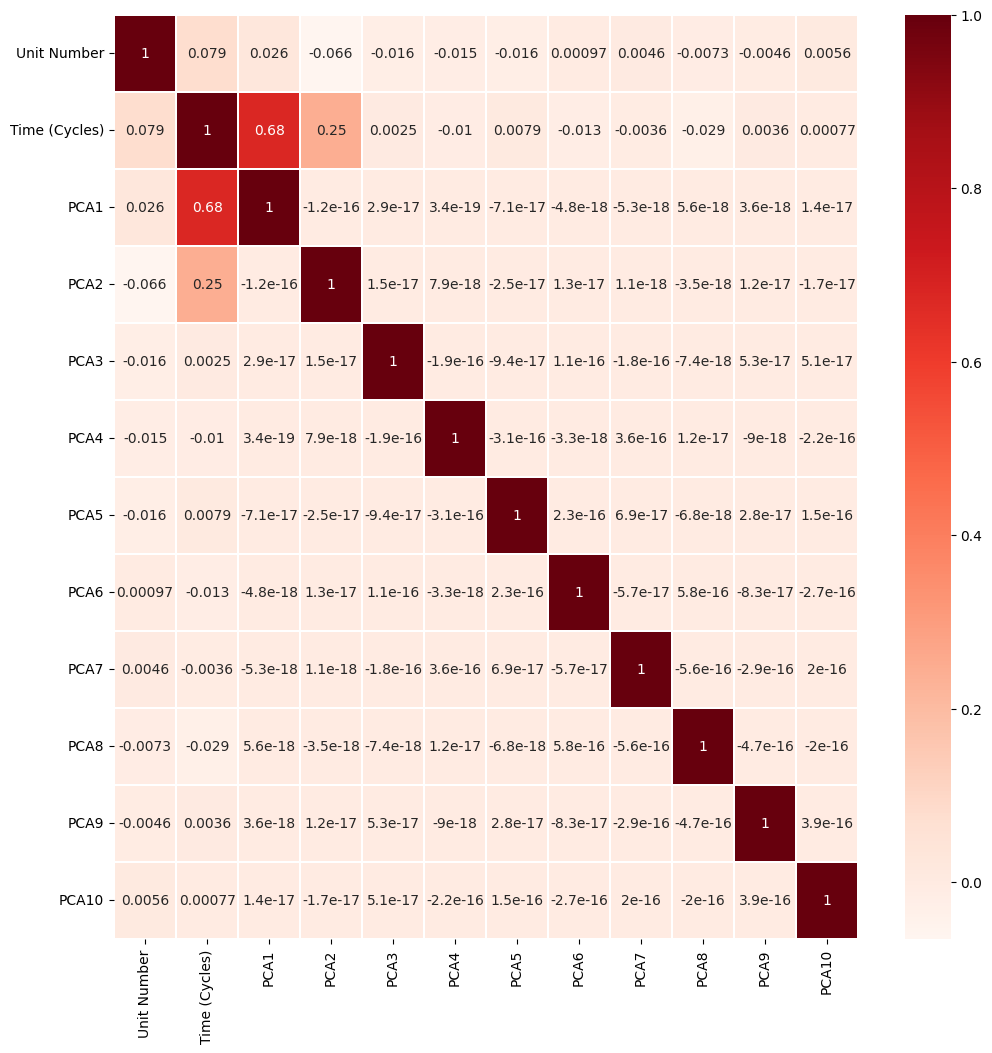



For FD002



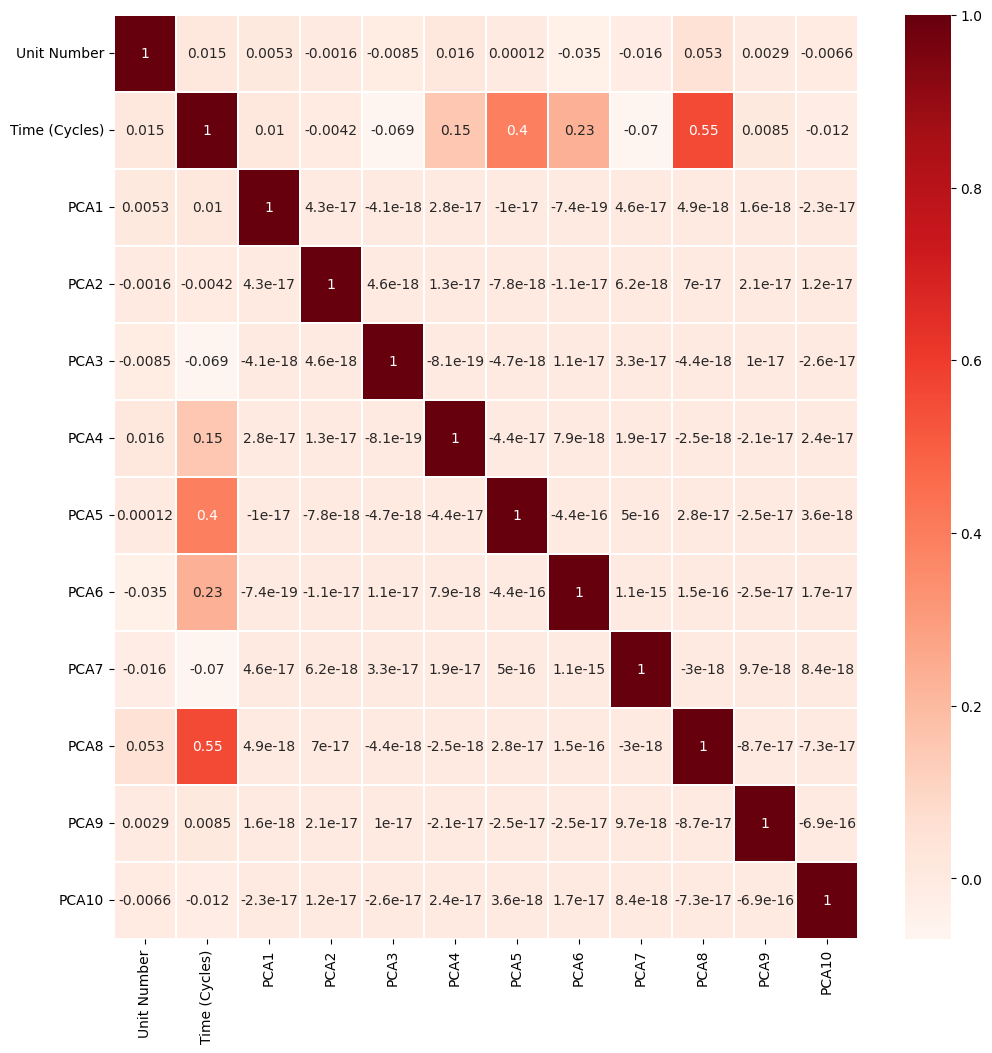



For FD003



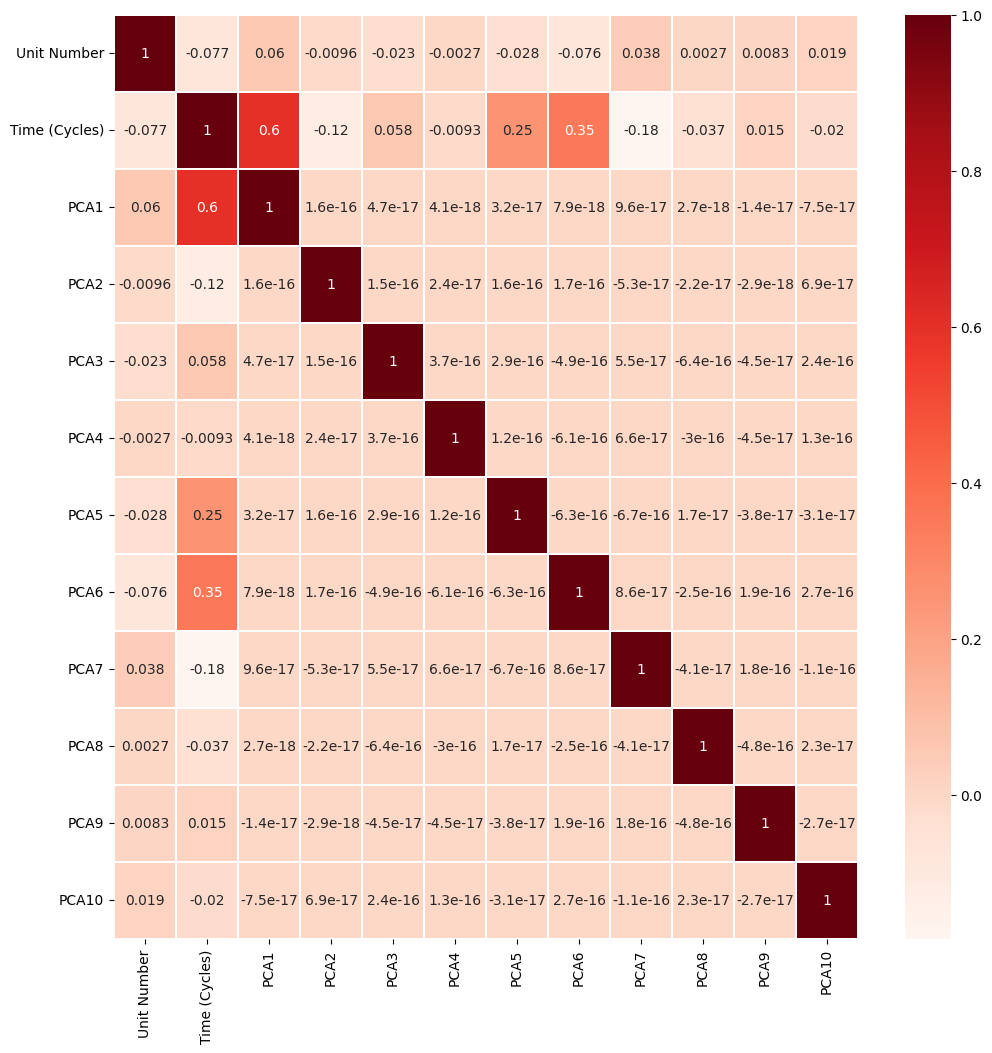



For FD004



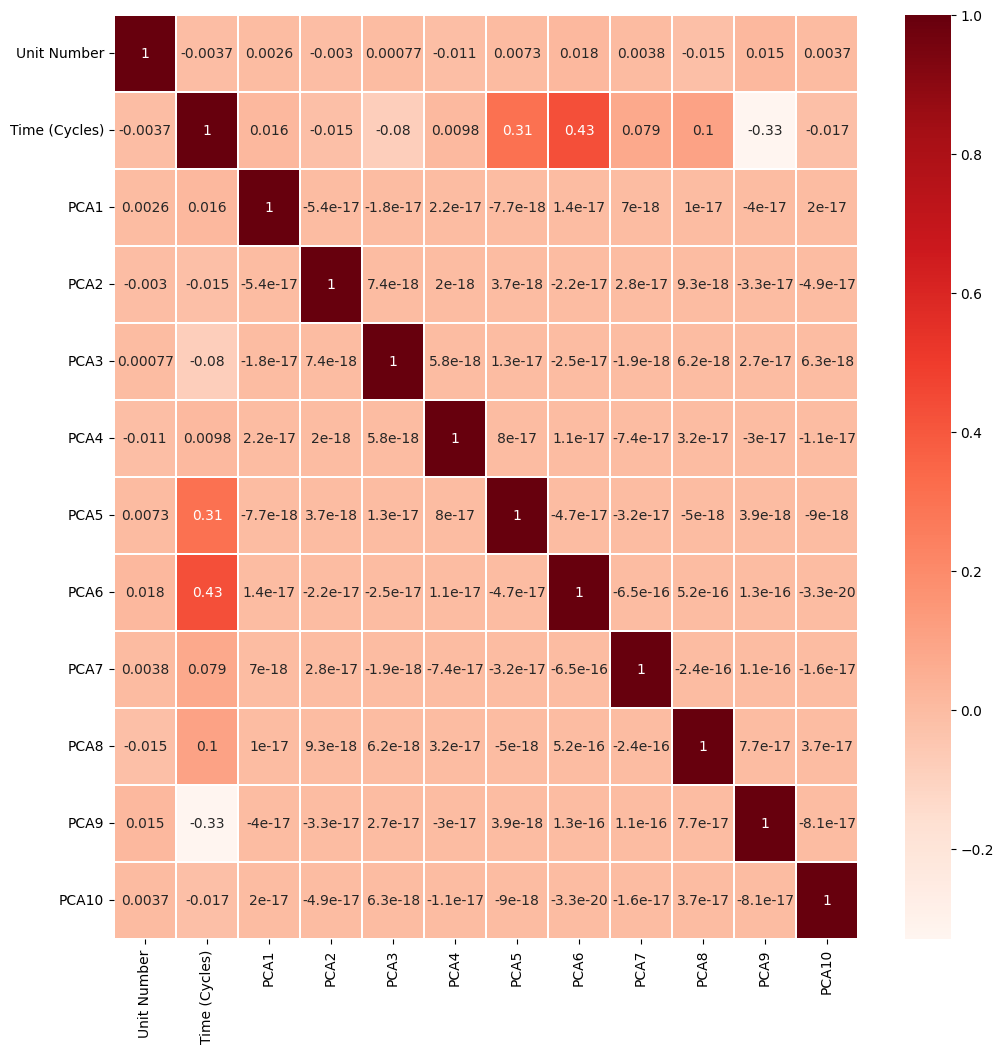

In [28]:
for i in range(4):
    print("For FD00" + str(i+1) + "\n")
    sns.heatmap(trainDatasetsCopy[i].corr(), annot=True, cmap="Reds", linewidths=0.2)
    fig = plt.gcf()
    fig.set_size_inches(12, 12)
    plt.show()
    print("\n")

### Processing Training Data

In [29]:
for i in range(4):
    temp1 = []
    temp2 = []
    for j in range(1, trainDatasetsUnique[i]+1):
        tempTrainDataset = trainDatasetsCopy[i][trainDatasetsCopy[i]['Unit Number'] == j].drop(columns = ['Unit Number']).values

        window_size = min(len(tempTrainDataset), defaultWindow)

        tempTrainRulDataset = trainRulDatasets[i][trainRulDatasets[i]['Unit Number'] == j].drop(columns = ['Unit Number']).values

        tempTrainDataset, tempTrainRulDataset = processTrainingData(tempTrainDataset, tempTrainRulDataset, window = window_size, shift = defaultShift)

        temp1.append(tempTrainDataset)
        temp2.append(tempTrainRulDataset)
        
    processedTrainDatasets.append(np.concatenate(temp1))
    processedTrainRulDatasets.append(np.concatenate(temp2))

### Processing Test Data

In [30]:
for i in range(4):
    temp1 = []
    temp2 = []
    for j in range(1, testDatasetsUnique[i]+1):
        tempTestDataset = testDatasetsCopy[i][testDatasetsCopy[i]['Unit Number'] == j].drop(columns = ['Unit Number']).values

        window_size = min(len(tempTestDataset), defaultWindow)

        tempTestDataset, testWindow = processTestingData(tempTestDataset, window = window_size, shift = defaultShift, testWindow = defaultTestWindow)

        temp1.append(tempTestDataset)
        temp2.append(testWindow)
        
    processedTestDatasets.append(np.concatenate(temp1))
    testWindowList.append(temp2)
    rulDatasets.append(expectedRulDatasetsCopy[i]["Expected RUL"].values)

### Showing Processed Data Shapes

In [31]:
for i in range(4):
    print("For FD00" + str(i+1) + "\n")
    print("Train Dataset Shape: ", processedTrainDatasets[i].shape)
    print("Train RUL Dataset Shape: ", processedTrainRulDatasets[i].shape)
    print("Test Dataset Shape: ", processedTestDatasets[i].shape)
    print("Expected RUL Shape: ", rulDatasets[i].shape)
    print("\n")

For FD001

Train Dataset Shape:  (19731, 10, 11)
Train RUL Dataset Shape:  (19731,)
Test Dataset Shape:  (1000, 10, 11)
Expected RUL Shape:  (100,)


For FD002

Train Dataset Shape:  (51419, 10, 11)
Train RUL Dataset Shape:  (51419,)
Test Dataset Shape:  (2590, 10, 11)
Expected RUL Shape:  (259,)


For FD003

Train Dataset Shape:  (23820, 10, 11)
Train RUL Dataset Shape:  (23820,)
Test Dataset Shape:  (1000, 10, 11)
Expected RUL Shape:  (100,)


For FD004

Train Dataset Shape:  (59008, 10, 11)
Train RUL Dataset Shape:  (59008,)
Test Dataset Shape:  (2480, 10, 11)
Expected RUL Shape:  (248,)




## LSTM Individual Model Training

In [32]:
trainedModel = []
histories = []

In [33]:
for i in range(4):
    print("For FD00" + str(i+1) + "\n")
    name = "FD00" + str(i+1)
    model = createModel(processedTrainDatasets[i].shape, name = name)
    display(model.summary())
    history = model.fit(processedTrainDatasets[i], processedTrainRulDatasets[i], epochs = 100, validation_split = 0.2, batch_size = 128, verbose = 1)
    print("\n")
    trainedModel.append(model)
    histories.append(history)

For FD001

Model: "FD001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           71680     
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 133537 (521.63 KB)
Trainable params: 133537 (521.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Epoch 1/100
124/124 [==============================] - 7s 27ms/step - loss: 13018.8457 - val_loss: 16963.7324
Epoch 2/100
124/124 [==============================] - 3s 20ms/step - loss: 12034.1240 - val_loss: 16087.4238
Epoch 3/100
124/124 [==============================] - 3s 20ms/step - loss: 11323.4238 - val_loss: 15304.2061
Epoch 4/100
124/124 [==============================] - 3s 21ms/step - loss: 10677.5205 - val_loss: 14580.8604
Epoch 5/100
124/124 [==============================] - 3s 21ms/step - loss: 10080.9863 - val_loss: 13905.4961
Epoch 6/100
124/124 [==============================] - 2s 20ms/step - loss: 9528.8223 - val_loss: 13274.4277
Epoch 7/100
124/124 [==============================] - 2s 20ms/step - loss: 9016.0771 - val_loss: 12683.0645
Epoch 8/100
124/124 [==============================] - 3s 20ms/step - loss: 8540.1650 - val_loss: 12131.4385
Epoch 9/100
124/124 [==============================] - 2s 20ms/step - loss: 8097.9814 - val_loss: 11615.5117
Epoch 10/100
1

None

Epoch 1/100
322/322 [==============================] - 11s 23ms/step - loss: 12888.8838 - val_loss: 11496.0713
Epoch 2/100
322/322 [==============================] - 7s 21ms/step - loss: 10938.7520 - val_loss: 9904.6162
Epoch 3/100
322/322 [==============================] - 7s 21ms/step - loss: 9475.3057 - val_loss: 8610.0215
Epoch 4/100
322/322 [==============================] - 7s 21ms/step - loss: 8279.6553 - val_loss: 7556.3975
Epoch 5/100
322/322 [==============================] - 7s 21ms/step - loss: 7125.6084 - val_loss: 6380.5615
Epoch 6/100
322/322 [==============================] - 7s 21ms/step - loss: 6106.2988 - val_loss: 5506.7900
Epoch 7/100
322/322 [==============================] - 7s 21ms/step - loss: 5278.0454 - val_loss: 4762.3457
Epoch 8/100
322/322 [==============================] - 7s 22ms/step - loss: 4580.5430 - val_loss: 4146.5410
Epoch 9/100
322/322 [==============================] - 7s 21ms/step - loss: 3986.5227 - val_loss: 3626.8381
Epoch 10/100
322/322 [==

None

Epoch 1/100
149/149 [==============================] - 8s 27ms/step - loss: 25006.9766 - val_loss: 25339.8379
Epoch 2/100
149/149 [==============================] - 3s 20ms/step - loss: 23415.4551 - val_loss: 24082.7266
Epoch 3/100
149/149 [==============================] - 3s 20ms/step - loss: 22253.4395 - val_loss: 22936.7402
Epoch 4/100
149/149 [==============================] - 3s 20ms/step - loss: 21179.2910 - val_loss: 21859.7832
Epoch 5/100
149/149 [==============================] - 3s 21ms/step - loss: 20159.8086 - val_loss: 20840.6055
Epoch 6/100
149/149 [==============================] - 3s 21ms/step - loss: 19204.0898 - val_loss: 19883.1602
Epoch 7/100
149/149 [==============================] - 3s 21ms/step - loss: 18302.8066 - val_loss: 18979.1836
Epoch 8/100
149/149 [==============================] - 3s 21ms/step - loss: 17451.8809 - val_loss: 18116.9043
Epoch 9/100
149/149 [==============================] - 3s 21ms/step - loss: 16646.6543 - val_loss: 17306.2930
Epoch 10/1

None

Epoch 1/100
369/369 [==============================] - 12s 23ms/step - loss: 21734.6953 - val_loss: 18082.9414
Epoch 2/100
369/369 [==============================] - 8s 21ms/step - loss: 18921.6621 - val_loss: 15765.0938
Epoch 3/100
369/369 [==============================] - 8s 21ms/step - loss: 16663.3945 - val_loss: 13725.0879
Epoch 4/100
369/369 [==============================] - 8s 21ms/step - loss: 14653.2148 - val_loss: 11963.3066
Epoch 5/100
369/369 [==============================] - 8s 21ms/step - loss: 12922.0615 - val_loss: 10456.4844
Epoch 6/100
369/369 [==============================] - 8s 21ms/step - loss: 11414.1396 - val_loss: 9138.9727
Epoch 7/100
369/369 [==============================] - 8s 21ms/step - loss: 10104.3047 - val_loss: 8013.0317
Epoch 8/100
369/369 [==============================] - 8s 21ms/step - loss: 8960.9902 - val_loss: 7045.4751
Epoch 9/100
369/369 [==============================] - 8s 21ms/step - loss: 7965.3662 - val_loss: 6212.6553
Epoch 10/100
36

## Individual Model Testing

### Predicting Values

In [34]:
for i in range(4):
    predictedRul = trainedModel[i].predict(processedTestDatasets[i]).reshape(-1)
    predictedRul = np.split(predictedRul, np.cumsum(testWindowList[i])[:-1])
    predictedRul = [np.average(ruls, weights = np.repeat(1/testWindow, testWindow)) for ruls, testWindow in zip(predictedRul, testWindowList[i])]

    predictedRulDatasets.append(predictedRul)

78/78 [==============================] - 1s 4ms/step


### Finding Root Mean Square Error

In [35]:
for i in range(4):
    rmse = np.sqrt(mse(rulDatasets[i], predictedRulDatasets[i]))
    print("For FD00" + str(i+1))
    print("Root Mean Square Error:", rmse)
    print("\n")
    rmseList.append(rmse)

For FD001
Root Mean Square Error: 28.08989067380077


For FD002
Root Mean Square Error: 31.918991737156944


For FD003
Root Mean Square Error: 42.68300216480351


For FD004
Root Mean Square Error: 42.90491290556605




### Finding R2 Score

In [36]:
for i in range(4):
    r2_sc = r2_score(rulDatasets[i], predictedRulDatasets[i])
    print("For FD00" + str(i+1))
    print("R2 Score:", r2_sc)
    print("\n")
    r2_scoreList.append(r2_sc)

For FD001
R2 Score: 0.543079594390868


For FD002
R2 Score: 0.6477295550107537


For FD003
R2 Score: -0.06316598120855277


For FD004
R2 Score: 0.3807843482254868




### Visualization

#### Expected RUL vs Predicted RUL

For FD001



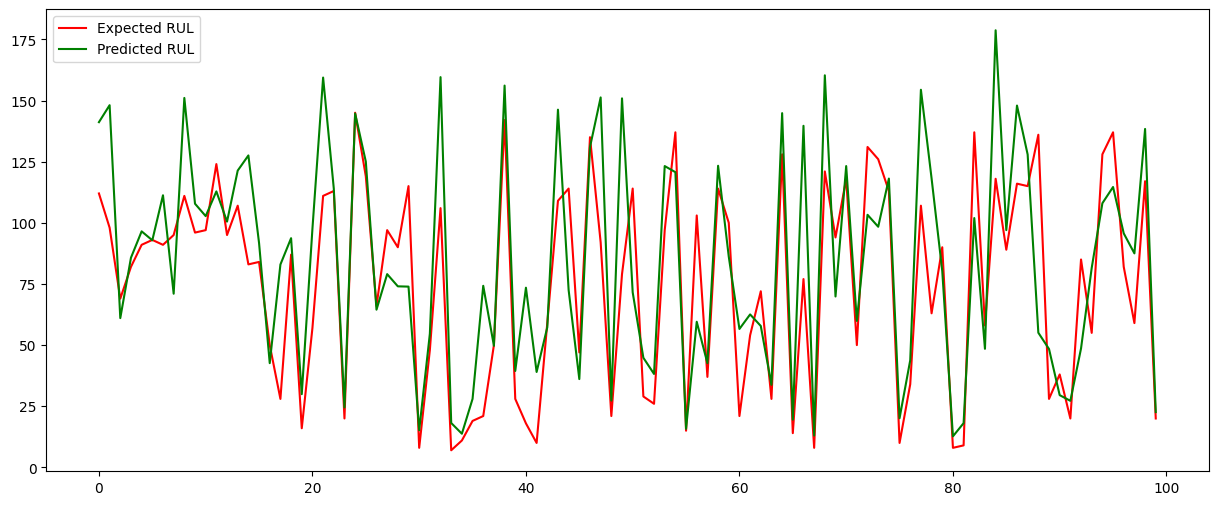



For FD002



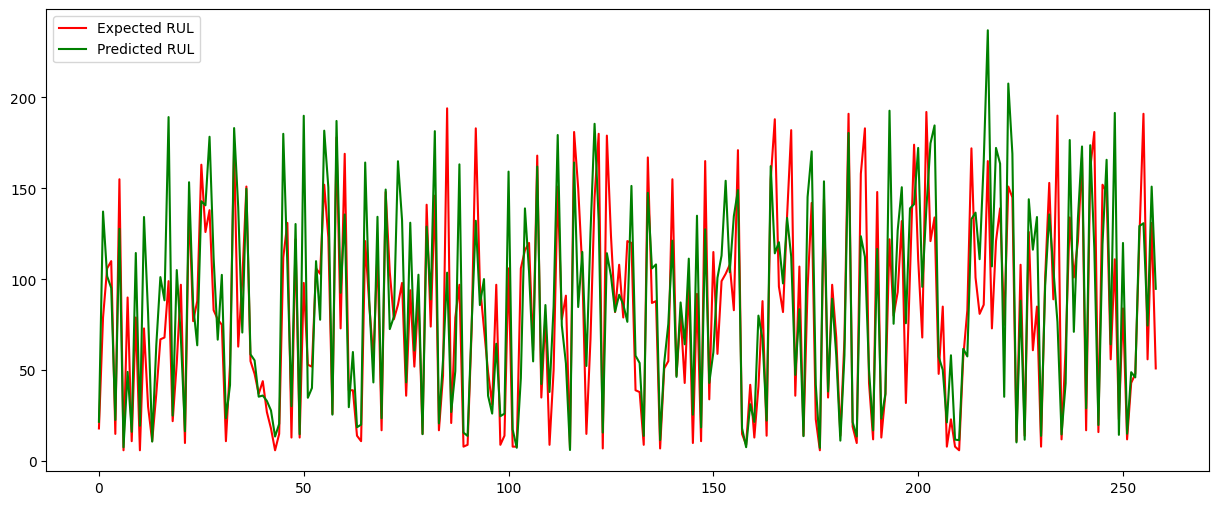



For FD003



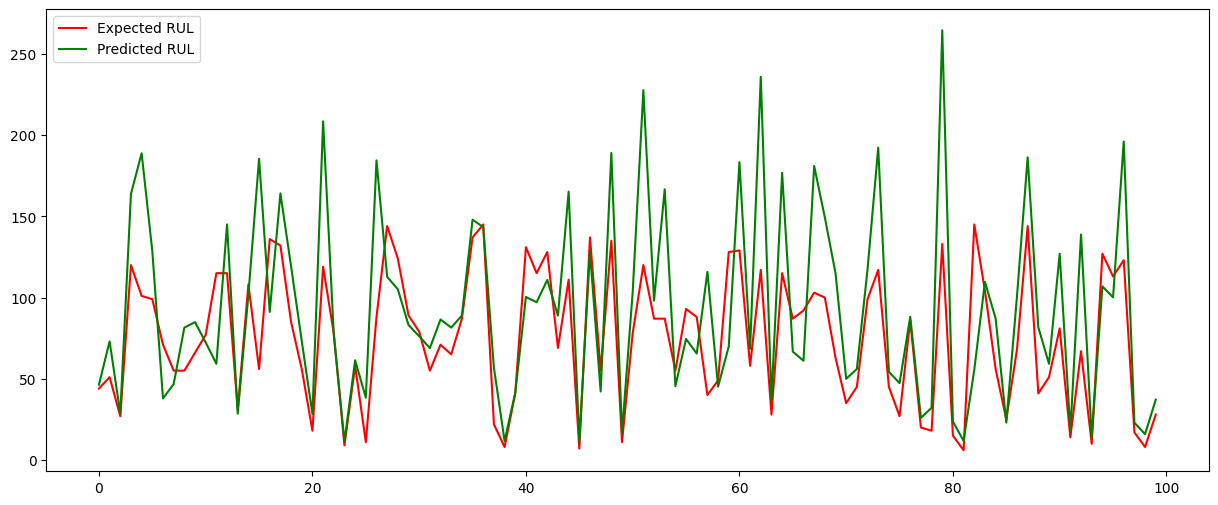



For FD004



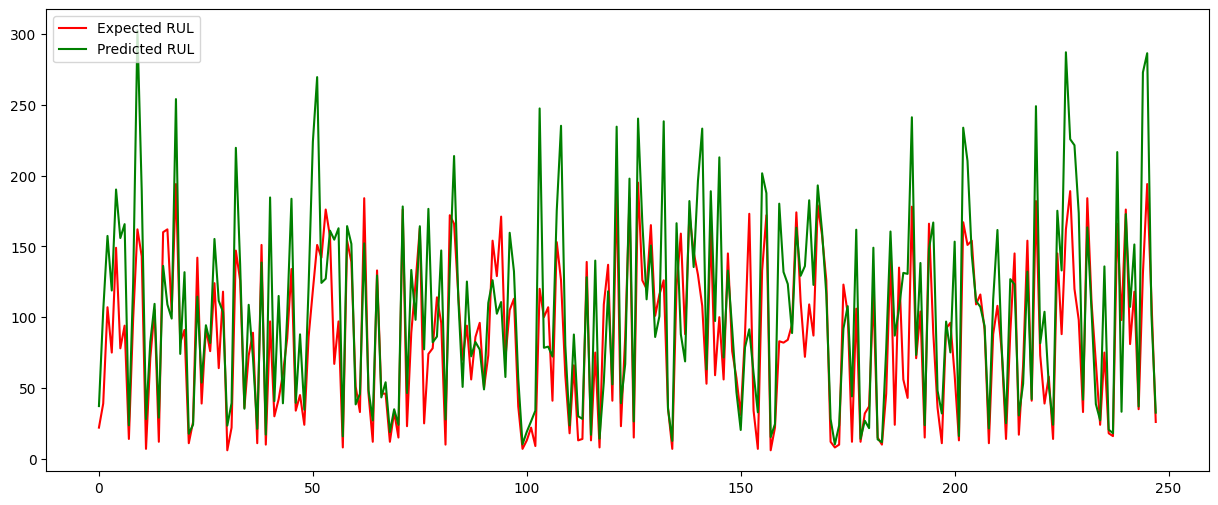

In [37]:
for i in range(4):
    print("For FD00" + str(i+1) + "\n")
    plt.figure(figsize = (15, 6))
    plt.plot(rulDatasets[i], label = "Expected RUL", color = "Red")
    plt.plot(predictedRulDatasets[i], label = "Predicted RUL", color = "Green")
    plt.legend(loc = 'upper left')
    plt.show()
    print("\n")

#### Training History

For FD001



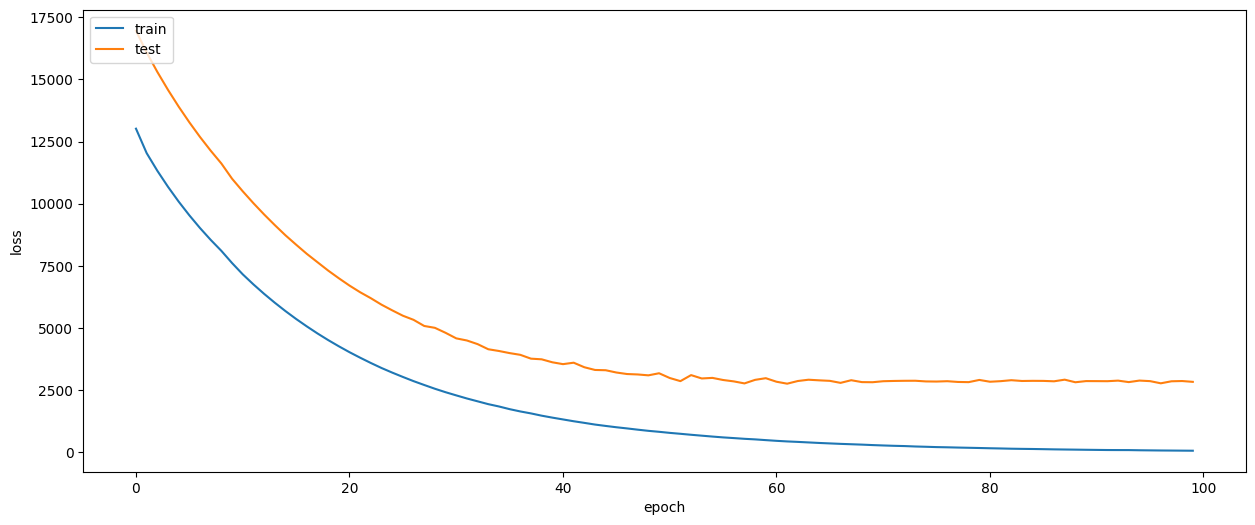



For FD002



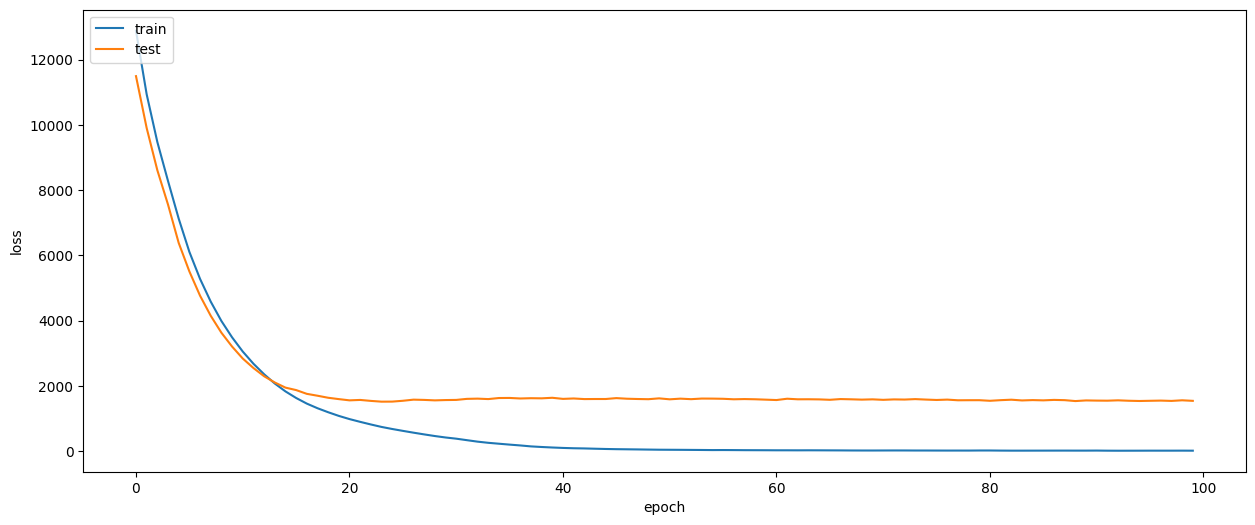



For FD003



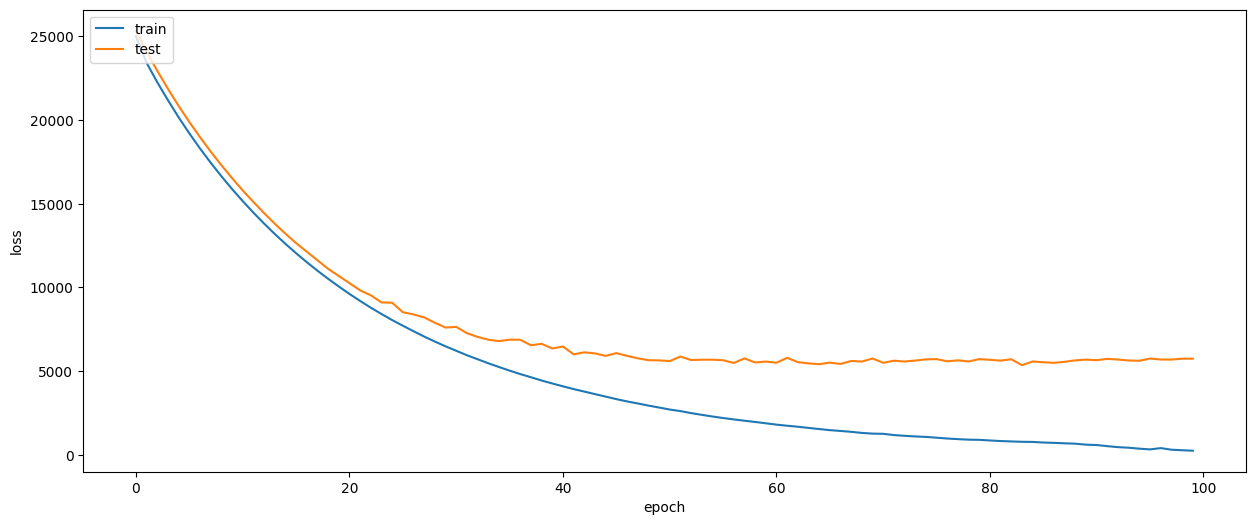



For FD004



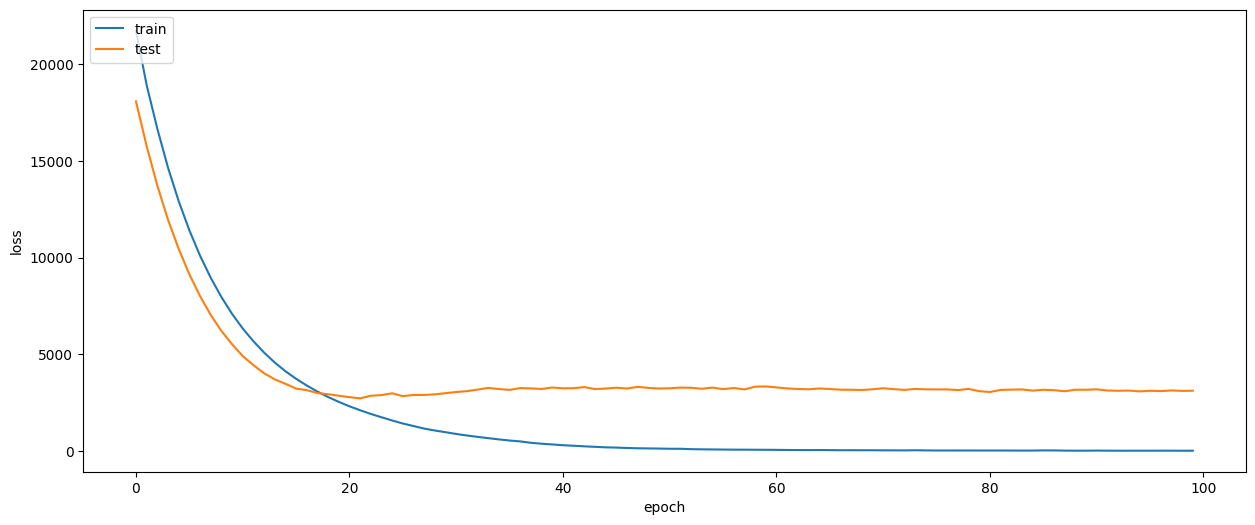

In [38]:
for i in range(4):
    print("For FD00" + str(i+1) + "\n")
    plt.figure(figsize = (15, 6))
    plt.plot(histories[i].history['loss'])
    plt.plot(histories[i].history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()
    print("\n")

## LSTM Complete Model Training

In [39]:
completeTrainDatasets = np.concatenate(processedTrainDatasets)
completeTrainRulDatasets = np.concatenate(processedTrainRulDatasets)
completeTestDatasets = np.concatenate(processedTestDatasets)
completeRulDatasets = np.concatenate(rulDatasets)
completeTestWindowList = np.concatenate(testWindowList)

### Shapes

In [40]:
print("Train Dataset Shape: ", completeTrainDatasets.shape)
print("Train RUL Dataset Shape: ", completeTrainRulDatasets.shape)
print("Test Dataset Shape: ", completeTestDatasets.shape)
print("Expected RUL Shape: ", completeRulDatasets.shape)

Train Dataset Shape:  (153978, 10, 11)
Train RUL Dataset Shape:  (153978,)
Test Dataset Shape:  (7070, 10, 11)
Expected RUL Shape:  (707,)


### Model Training

In [41]:
completeModel = createModel(completeTrainDatasets.shape)
completeHistory = completeModel.fit(completeTrainDatasets, completeTrainRulDatasets, epochs = 100, validation_split = 0.2, batch_size = 128, verbose = 1)

Epoch 1/100
963/963 [==============================] - 24s 21ms/step - loss: 15133.0908 - val_loss: 16182.6729
Epoch 2/100
963/963 [==============================] - 21s 22ms/step - loss: 10453.1113 - val_loss: 11720.3135
Epoch 3/100
963/963 [==============================] - 21s 22ms/step - loss: 7300.2480 - val_loss: 8630.9805
Epoch 4/100
963/963 [==============================] - 21s 21ms/step - loss: 5251.8076 - val_loss: 6608.2705
Epoch 5/100
963/963 [==============================] - 21s 22ms/step - loss: 3914.2273 - val_loss: 5215.6396
Epoch 6/100
963/963 [==============================] - 20s 21ms/step - loss: 3048.8066 - val_loss: 4386.8555
Epoch 7/100
963/963 [==============================] - 20s 21ms/step - loss: 2491.2522 - val_loss: 3890.9932
Epoch 8/100
963/963 [==============================] - 20s 21ms/step - loss: 2106.1038 - val_loss: 3510.9338
Epoch 9/100
963/963 [==============================] - 20s 21ms/step - loss: 1817.4663 - val_loss: 3490.2083
Epoch 10/100
96

## Complete Model Testing

### Predicting Values

In [42]:
completePredictedRul = completeModel.predict(completeTestDatasets).reshape(-1)
completePredictedRul = np.split(completePredictedRul, np.cumsum(completeTestWindowList)[:-1])
completePredictedRul = [np.average(ruls, weights = np.repeat(1/testWindow, testWindow)) for ruls, testWindow in zip(completePredictedRul, completeTestWindowList)]

221/221 [==============================] - 2s 3ms/step


### Finding Root Mean Square Error

In [43]:
rmse = np.sqrt(mse(completeRulDatasets, completePredictedRul))
print("Root Mean Square Error:", rmse)

Root Mean Square Error: 37.6634182481635


### Finding R2 Score

In [44]:
r2_sc = r2_score(completeRulDatasets, completePredictedRul)
print("R2 Score:", r2_sc)

R2 Score: 0.45616474375126903


### Visualization

#### Expected RUL vs Predicted RUL

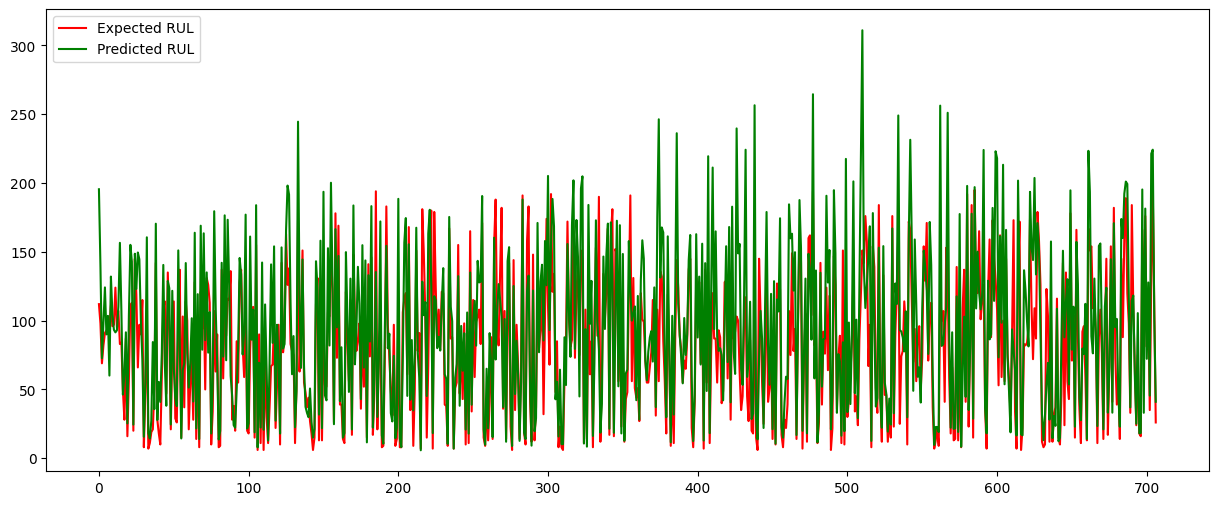

In [45]:
plt.figure(figsize = (15, 6))
plt.plot(completeRulDatasets, label = "Expected RUL", color = "Red")
plt.plot(completePredictedRul, label = "Predicted RUL", color = "Green")
plt.legend(loc = 'upper left')
plt.show()

#### Training History

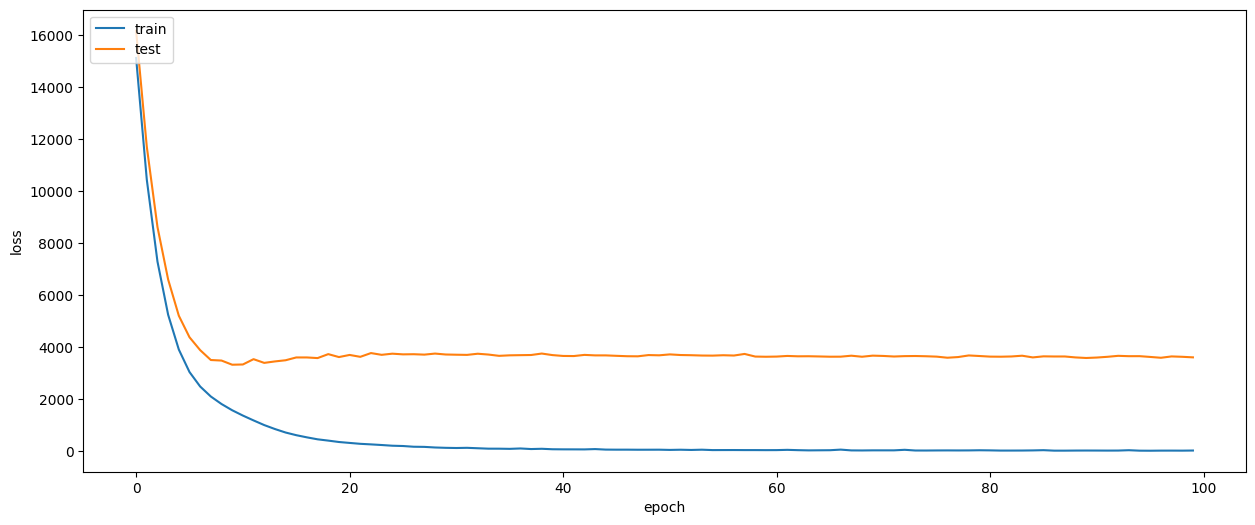

In [46]:
plt.figure(figsize = (15, 6))
plt.plot(completeHistory.history['loss'])
plt.plot(completeHistory.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

## Saving Models

In [47]:
modelDumpFolder = 'D:/IIT DHANBAD/Seventh semester/CSC 401- Project - I -PI/Practice/Models/'

modelDumpFiles = ['FD001.pkl', 'FD002.pkl', 'FD003.pkl', 'FD004.pkl', 'complete.pkl']

### Individual Models

In [48]:
for i in range(4):
    pickle.dump(trainedModel[i], open(modelDumpFolder + modelDumpFiles[i], 'wb'))

### Complete Model

In [49]:
pickle.dump(completeModel, open(modelDumpFolder + modelDumpFiles[i], 'wb'))

# Completed